In [1]:
import requests
import pickle
import io

model_names = ["DeepConvNet", "ShallowConvNet", "EEGNet", "DMTL_BCI", "TCNet_fusion", 
               "PST_attention", "IRKCS-FCnet"]
results = {}

for name in model_names:
    if name == "TCNet_fusion":
        results[name] = []
        for i in range(1,4):
            url = f'https://raw.githubusercontent.com/UN-GCPDS/eeg_models/main/examples/results/results_{name}_{i}.pkl'
            response = requests.get(url)
            results[name] = results[name] + pickle.load(io.BytesIO(response.content))
    else:        
        url = f'https://raw.githubusercontent.com/UN-GCPDS/eeg_models/main/examples/results/results_{name}.pkl'
        response = requests.get(url)
        results[name] = pickle.load(io.BytesIO(response.content))

In [2]:
import numpy as np

all_mean_acc = {}

for name in results.keys():
    all_mean_acc[name] = 0
    for a,b in results[name]:
        all_mean_acc[name] += b['mean_acc']
    all_mean_acc[name] = all_mean_acc[name]/50

In [3]:
all_mean_acc

{'DeepConvNet': 0.8125799999999999,
 'ShallowConvNet': 0.8574000000000004,
 'EEGNet': 0.8869800000000001,
 'DMTL_BCI': 0.8150799999999998,
 'TCNet_fusion': 0.9201599999999998,
 'PST_attention': 0.8438000000000001,
 'IRKCS-FCnet': 0.7513799999999997}

In [4]:
results_acc = {}
results_auc = {}
results_kappa = {}

for key in results.keys():
    results_acc[key] = []
    results_auc[key] = []
    results_kappa[key] = []
    for _, metrics in results[key]:
        results_acc[key].append(metrics['mean_acc']*100)
        results_auc[key].append(metrics['mean_auc']*100)
        results_kappa[key].append(metrics['mean_kappa']*100)

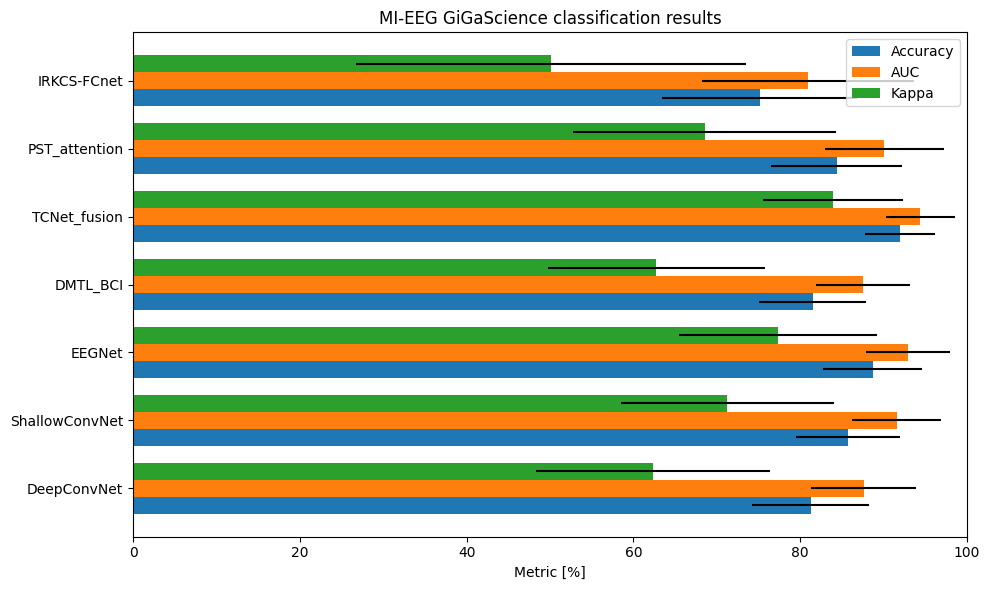

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Promedios y desviaciones estándar
models = list(results_acc.keys())
mean_acc = [np.mean(results_acc[m]) for m in models]
std_acc = [np.std(results_acc[m]) for m in models]

mean_auc = [np.mean(results_auc[m]) for m in models]
std_auc = [np.std(results_auc[m]) for m in models]

mean_kappa = [np.mean(results_kappa[m]) for m in models]
std_kappa = [np.std(results_kappa[m]) for m in models]

x = np.arange(len(models))  # ubicaciones de los modelos
width = 0.25  # ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

# Barras de precisión
acc_bars = ax.barh(x - width, mean_acc, height=width, xerr=std_acc, label='Accuracy', align='center')
# Barras de AUC
auc_bars = ax.barh(x, mean_auc, height=width, xerr=std_auc, label='AUC', align='center')
# Barras de Kappa
kappa_bars = ax.barh(x + width, mean_kappa, height=width, xerr=std_kappa, label='Kappa', align='center')

# Etiquetas
ax.set_yticks(x)
ax.set_yticklabels(models)
ax.set_xlabel('Metric [%]')
ax.set_xlim(0, 100)
ax.legend()
ax.set_title('MI-EEG GiGaScience classification results')

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd

subjects = []
for sbj, _ in results['DeepConvNet']:
    subjects.append(sbj)

df_acc = results_acc.copy()
df_acc['Subject'] = subjects
df_acc  =  pd.DataFrame(df_acc)

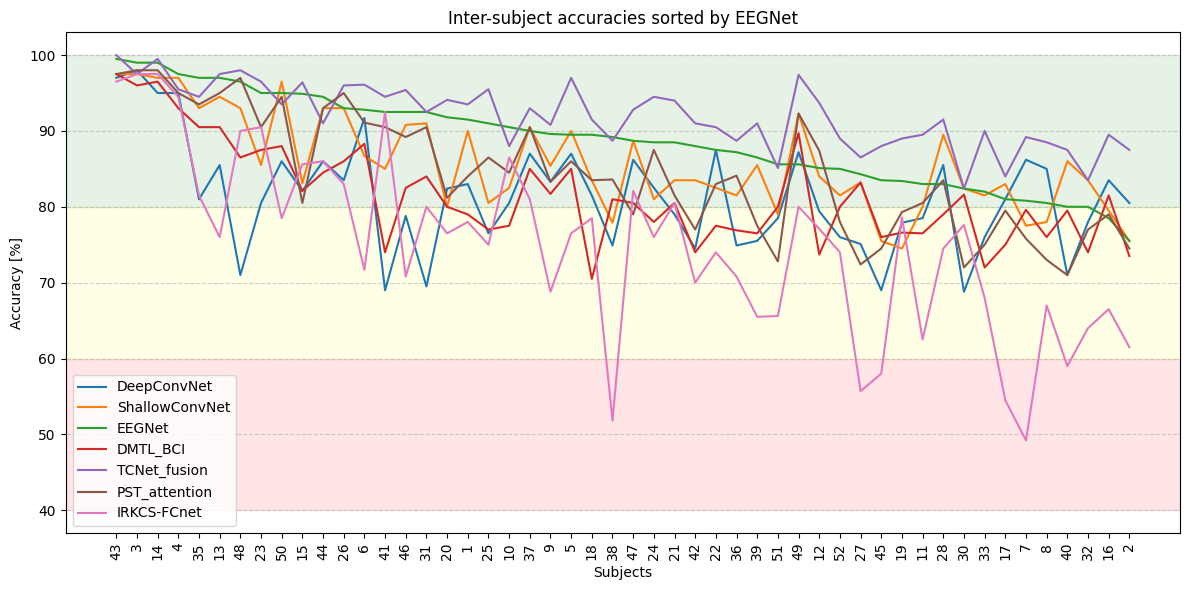

In [7]:
import matplotlib.pyplot as plt

# Extraer el dataframe de accuracy
# df_acc = dataframes['mean_accuracy']

# Ordenar por EEGNet (de mayor a menor)
df_sorted = df_acc.sort_values(by="EEGNet", ascending=False).reset_index(drop=True)

# Reordenar columnas para graficar (excluyendo 'Subject')
model_names = [col for col in df_sorted.columns if col != "Subject"]

# Crear gráfico de líneas
plt.figure(figsize=(12, 6))

# Graficar cada modelo
for model in model_names:
    plt.plot(df_sorted[model], label=model)

# Personalización del gráfico
plt.axhspan(80, 100, color="green", alpha=0.1)
plt.axhspan(60, 80, color="yellow", alpha=0.1)
# plt.axhspan(55, 70, color="orange", alpha=0.1)
plt.axhspan(40, 60, color="red", alpha=0.1)

plt.ylabel("Accuracy [%]")
plt.xlabel("Subjects")
plt.xticks(ticks=range(len(df_sorted)), labels=df_sorted["Subject"], rotation=90)
plt.title("Inter-subject accuracies sorted by EEGNet")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


In [8]:
import pandas as pd
from scipy.stats import ttest_ind
import itertools
import seaborn as sns

df = pd.DataFrame(df_acc)
df = df.drop('Subject', axis=1)

# Crear combinaciones de pares de modelos
model_names = list(df.columns)
ttest_results = pd.DataFrame(index=model_names, columns=model_names)

# Calcular el p-valor del t-test para cada par de modelos
for model1, model2 in itertools.product(model_names, repeat=2):
    stat, pval = ttest_ind(df[model1], df[model2])
    ttest_results.loc[model1, model2] = pval

ttest_results

,DeepConvNet,ShallowConvNet,EEGNet,DMTL_BCI,TCNet_fusion,PST_attention,IRKCS-FCnet
DeepConvNet,1.0,0.001201,0.0,0.854287,0.0,0.040063,0.002177
ShallowConvNet,0.001201,1.0,0.018436,0.001354,0.0,0.344939,0.0
EEGNet,0.0,0.018436,1.0,0.0,0.001876,0.002711,0.0
DMTL_BCI,0.854287,0.001354,0.0,1.0,0.0,0.049861,0.001155
TCNet_fusion,0.0,0.0,0.001876,0.0,1.0,0.0,0.0
PST_attention,0.040063,0.344939,0.002711,0.049861,0.0,1.0,0.000012
IRKCS-FCnet,0.002177,0.0,0.0,0.001155,0.0,0.000012,1.0


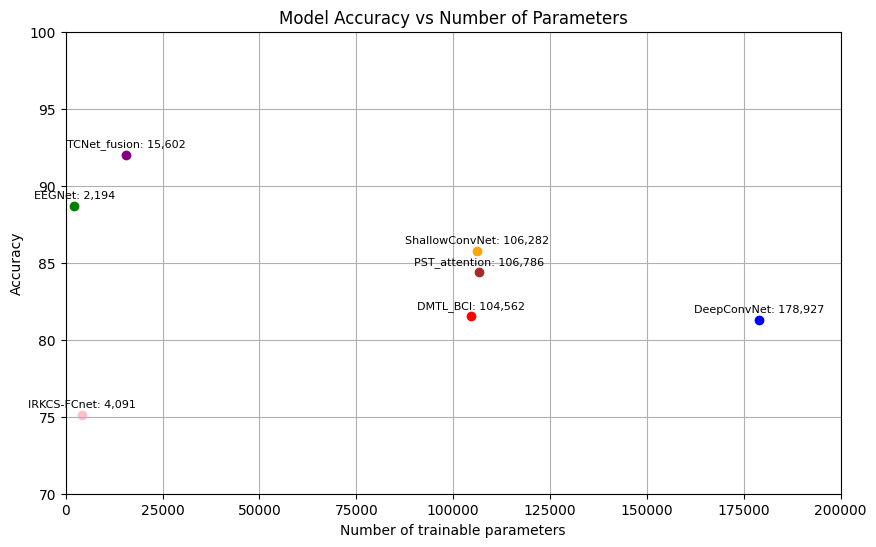

In [9]:
import matplotlib.pyplot as plt

# Model names
models = [
    'DeepConvNet', 
    'ShallowConvNet', 
    'EEGNet', 
    'DMTL_BCI', 
    'TCNet_fusion', 
    'PST_attention', 
    'IRKCS-FCnet'
]

# Synthetic values for number of parameters and accuracy
parameters = [178927, 106282, 2194, 104562, 15602, 106786, 4091]
accuracy = np.array(list(all_mean_acc.values()))*100

# Colors matching the legend
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

# Create plot
plt.figure(figsize=(10, 6))
for model, param, acc, color in zip(models, parameters, accuracy, colors):
    plt.scatter(param, acc, color=color)
    plt.text(param, acc+0.5, f'{model}: {param:,}', fontsize=8, ha='center')

plt.xlabel('Number of trainable parameters')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Number of Parameters')
plt.grid(True)
plt.xlim(0, 200000)
plt.ylim(70, 100)
plt.show()